In [77]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window

### DATA SET
The normals were established by clinical examination and history. 
The abnormal signals were collected from symptomatic patients scheduled to undergo
arthroscopy independent of the VAG studies.

Each subject sat on a rigid table in a relaxed position with the leg
being tested freely suspended in air. The VAG signal was recorded
by an accelerometer (model 3115a, Dytran, Chatsworth, CA), placed
at the mid-patella position of the knee, as the subject swung the
leg over an approximate angle range of 135◦ (approximately full
flexion) to 0◦ (full extension) and back to 135◦ in 4 s [16]. The first
half (approximately) of each VAG signal corresponds to extension
and the second half to flexion of the leg.

The database used in the present study consists of 89 signals, with 51 from normal volunteers (22 male, 29 female, age
28 ± 9.5 years) and 38 from subjects with knee-joint pathology (20
male, 28 female, age 35 ± 13.8 years).


In [78]:
data_path = "../data/open_vag/normal/novag1"
normal_dir = "../data/open_vag/normal/"
pathology_dir = "../data/open_vag/pathology/"

normal_vag_subjects = [] # 51
pathology_vag_subjects = [] # 38

# read all the files in the normal folder
novag_base_f = "novag"
ab_base_f  = "abvag"

# read normal files
for i, filename in enumerate(os.listdir(normal_dir)):
    file_path = os.path.join(normal_dir, f"{novag_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        vags = [float(x) for x in file.read().split()]
        normal_vag_subjects.append(vags)
        
# read pathology files
for i, filename in enumerate(os.listdir(pathology_dir)):
    file_path = os.path.join(pathology_dir, f"{ab_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        p_vags = [float(x) for x in file.read().split()]
        pathology_vag_subjects.append(p_vags)

print(f"{len(normal_vag_subjects)} normal subjects")
print(f"{len(pathology_vag_subjects)} pathology subjects")

51 normal subjects
38 pathology subjects


In [79]:
# amplitude normalisation
def amplitude_normal(data):
    data = np.array(data)
    data_min = min(data)
    data_max = max(data)
    normal = (data - data_min) / (data_max - data_min)
    return normal.tolist()

In [80]:
# variables
fs = 2000 # 2khz sampling rate

print(f"{len(normal_vag_subjects[38])} length of first normal subject data set")
print(f"{len(pathology_vag_subjects[28])} length of first pathology subject data set")

8000 length of first normal subject data set
8000 length of first pathology subject data set


In [81]:

#sub = 10
#n_norm_vag_1 = amplitude_normal(normal_vag_subjects[sub])
#p_norm_vag_1 = amplitude_normal(pathology_vag_subjects[sub])

# normalise the data sets

n_norm = []
p_norm = []

for d_set in normal_vag_subjects:
    n = amplitude_normal(d_set)
    n_norm.append(n)

for d_set in pathology_vag_subjects:
    n = amplitude_normal(d_set)
    p_norm.append(n)

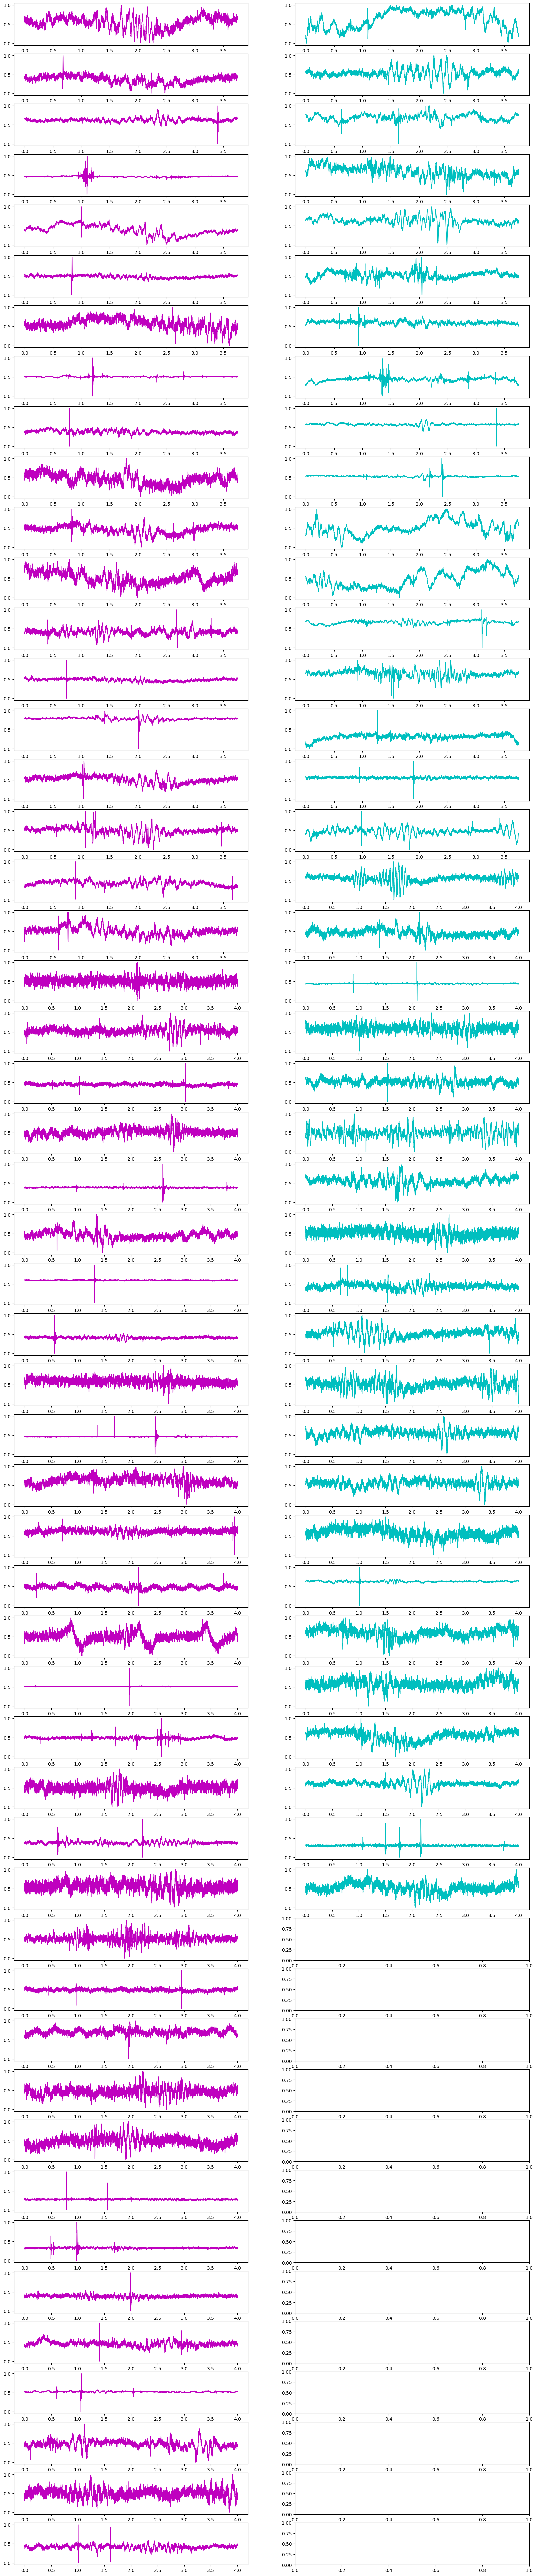

In [82]:
# plot the first normal and the first pathology subjects

fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm):
    t_n = np.arange(1, len(d) + 1) / fs
    ax[i][0].plot(t_n, d, color="m")
    if i < len(p_norm):
        t_p = np.arange(1, len(p_norm[i])+1) / fs
        ax[i][1].plot(t_p, p_norm[i], color="c")

In [83]:
# functions

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a
                 
def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

def compute_fft_mag(data):
    fftpoints = 512 #nt(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) #/ (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

def fft_graph_values(data, sample_rate):
    T = 1/sample_rate
    N_r =len(data)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(data)//2).tolist()
    y = data[:N_r]
    return [x,y]

In [88]:
# build a filter

low_cut_off = 10 # removes muscle artifacts and baseline wander
high_cut_off = 900
filter_order = 5   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass"
b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)

In [89]:


# data sets n_norm and p_norm
n_norm_f = []
p_norm_f = []

n_norm_pwr = []
p_norm_pwr = []

n_norm_total_pwr = []
p_norm_total_pwr = []

for d_set in n_norm:
    d_set_f = filter_signal(b,a, d_set, "filtfilt")
    fft_mag = compute_fft_mag(d_set_f)
    fft_graph = fft_graph_values(fft_mag, fs)
    f_power = compute_power_spectrum(fft_graph[1])
    total_power =  round(np.sum(f_power),2)
    n_norm_f.append(fft_graph)
    n_norm_pwr.append(f_power)
    n_norm_total_pwr.append(total_power)

for d_set in p_norm:
    d_set_f = filter_signal(b,a, d_set, "filtfilt")
    fft_mag = compute_fft_mag(d_set_f)
    fft_graph = fft_graph_values(fft_mag, fs)
    f_power = compute_power_spectrum(fft_graph[1])
    total_power =  round(np.sum(f_power),2)
    p_norm_f.append(fft_graph)
    p_norm_pwr.append(f_power)
    p_norm_total_pwr.append(total_power)



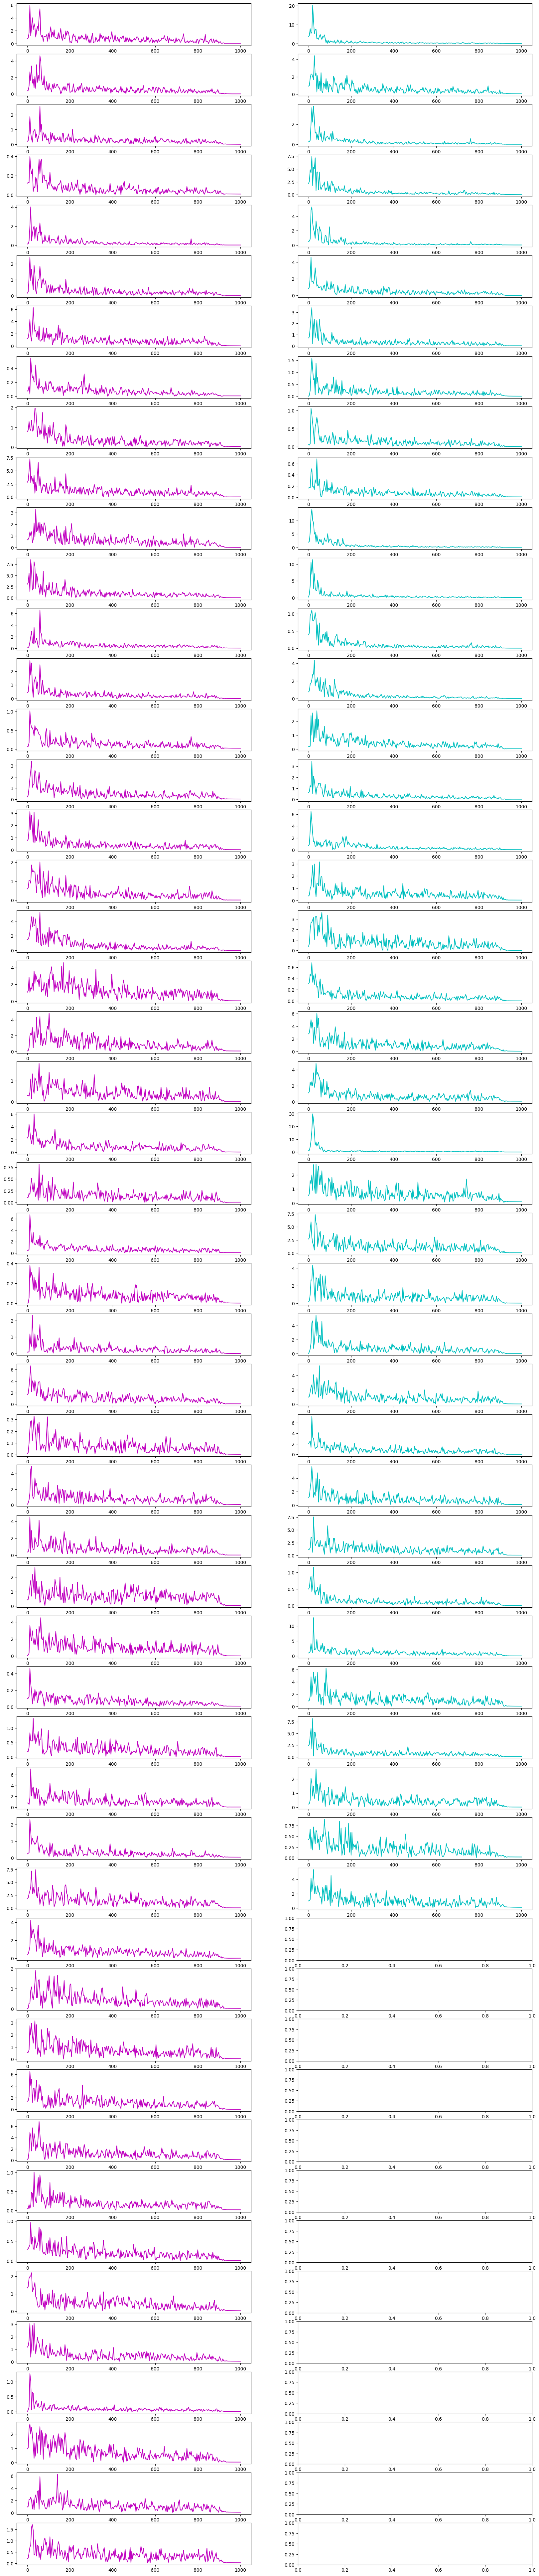

In [90]:
fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm_f):
    ax[i][0].plot(n_norm_f[i][0], n_norm_f[i][1], color="m")
    if i < len(p_norm):
        ax[i][1].plot(p_norm_f[i][0], p_norm_f[i][1], color="c")

In [128]:
# band percentages

n_norm_fb = []
p_norm_fb = []

# 50Hz bands up to the nyquist range
f_bands = [(f, f + 50) for f in range(50, 1000, 50)]
interval_axis = []
for (low, high) in f_bands:
    interval_axis.append(f"{low}-{high}")

for i, d_set in enumerate(n_norm_f):
    fft_freq = np.array(n_norm_f[i][0])
    band_powers = []
    for (low, high) in f_bands:
        band_power = np.sum(n_norm_pwr[i][(fft_freq >= low) & (fft_freq < high)])
        band_powers.append(band_power)

    # computes the percentage contribution of each frequency band
    band_percentages = [(bp / n_norm_total_pwr[i]) * 100 for bp in band_powers]
    n_norm_fb.append(band_percentages)

for i, d_set in enumerate(p_norm_f):
    fft_freq = np.array(p_norm_f[i][0])
    band_powers = []
    for (low, high) in f_bands:
        band_power = np.sum(p_norm_pwr[i][(fft_freq >= low) & (fft_freq < high)])
        band_powers.append(band_power)

    # computes the percentage contribution of each frequency band
    band_percentages = [(bp / p_norm_total_pwr[i]) * 100 for bp in band_powers]
    p_norm_fb.append(band_percentages)

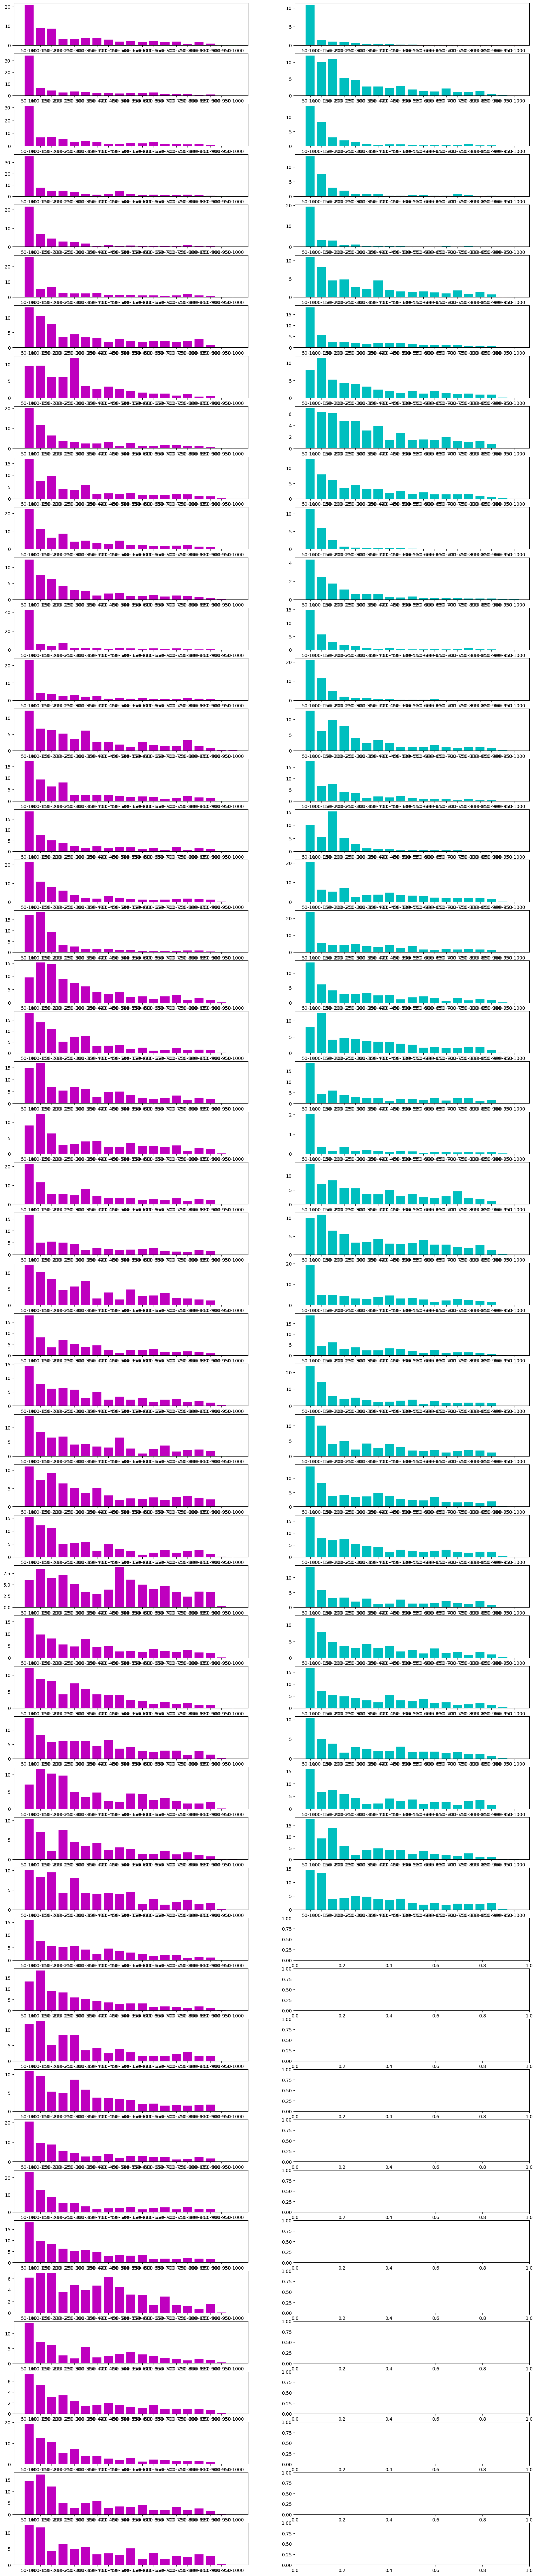

In [129]:
fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm_fb):
    ax[i][0].bar(interval_axis, d, color="m")
    if i < len(p_norm_fb):
        ax[i][1].bar(interval_axis, p_norm_fb[i], color="c")


In [192]:
from scipy.stats import linregress

segment_length = 1024  # Length of each segment
overlap = segment_length // 2  # 50% overlap
window = get_window('hann', segment_length)  # Hann window

n_norm_welch = []
p_norm_welch = []
n_slope = []
p_slope = []
for i, d_set in enumerate(n_norm):
    d_set_f = np.array(n_norm[i])
    #d_set_f = filter_signal(b,a, n_norm[i], "filtfilt")
    # Compute the power spectral density
    f_welch, psd = welch(d_set_f, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')
    frequencies, times, Sxx = spectrogram(d_set_f, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

    indices = np.where((f_welch > 10) & (f_welch < 300))[0]
    slope, intercept, r_value, p_value, std_err = linregress(indices, psd[indices])
    n_slope.append(slope)
    n_norm_welch.append([f_welch, psd, times, frequencies, Sxx])

for i, d_set in enumerate(p_norm):
    d_set_f = np.array(p_norm[i])
    #d_set_f = filter_signal(b,a, p_norm[i], "filtfilt")
    # Compute the power spectral density
    f_welch, psd = welch(d_set_f, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')
    frequencies, times, Sxx = spectrogram(d_set_f, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')
    indices = np.where((f_welch > 10) & (f_welch < 300))[0]
    slope, intercept, r_value, p_value, std_err = linregress(indices, psd[indices])
    slope, intercept, r_value, p_value, std_err = linregress(f_welch, psd)
    p_slope.append(slope)
    p_norm_welch.append([f_welch, psd, times, frequencies, Sxx])



-2.3688595158518526e-07
-3.855716215150846e-08


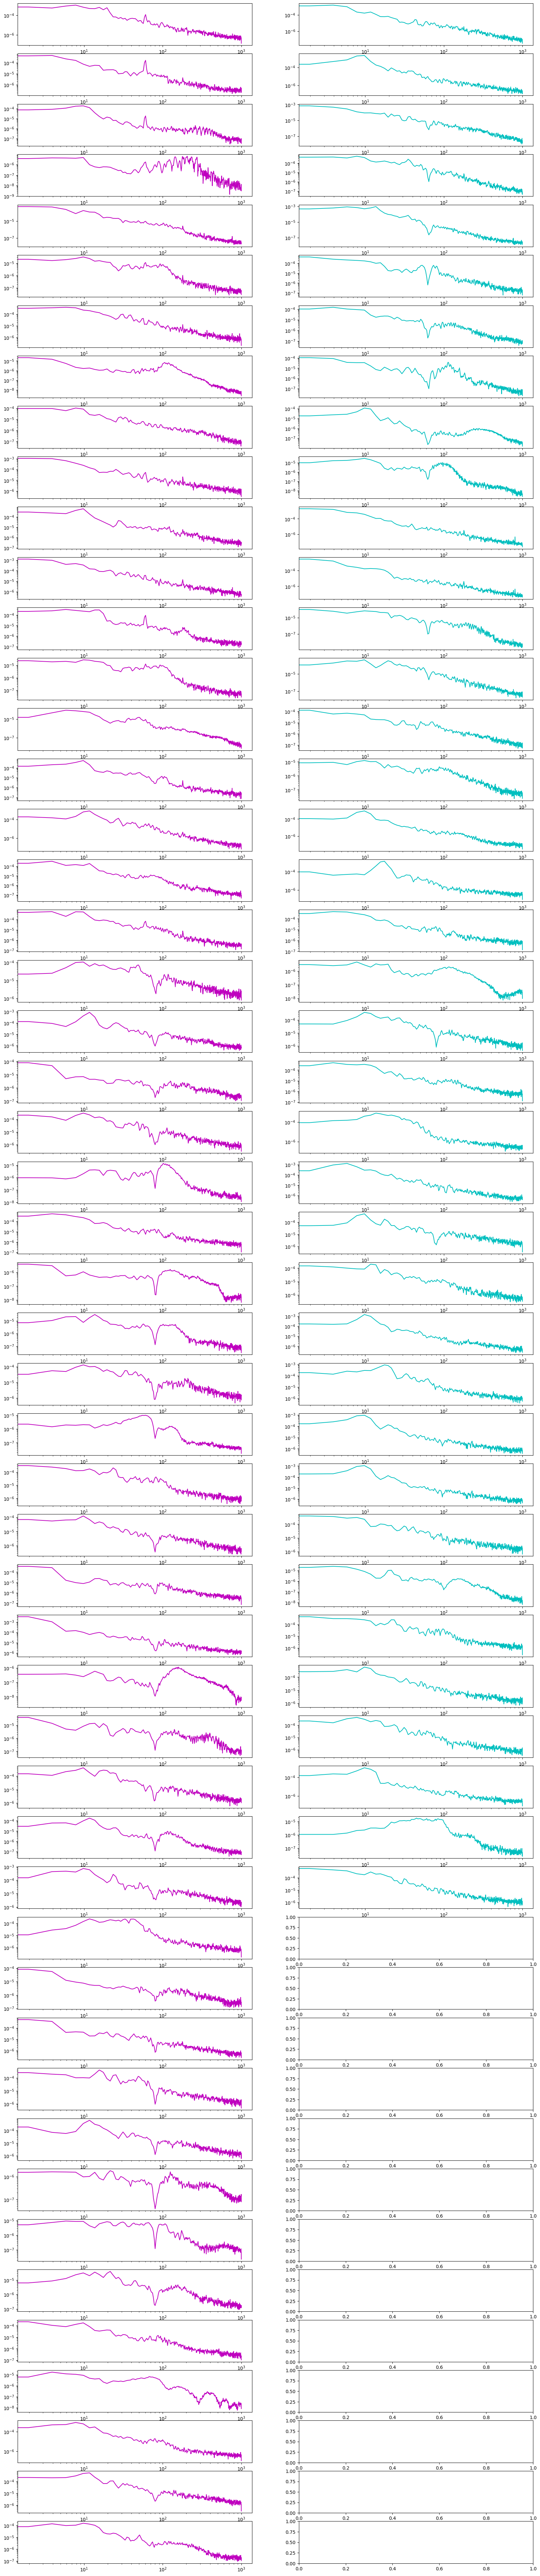

In [187]:
fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm_welch):
    ax[i][0].loglog(n_norm_welch[i][0], n_norm_welch[i][1], color="m")
    if i < len(p_norm_fb):
        ax[i][1].loglog(p_norm_welch[i][0], p_norm_welch[i][1], color="c")
#ax[0].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')

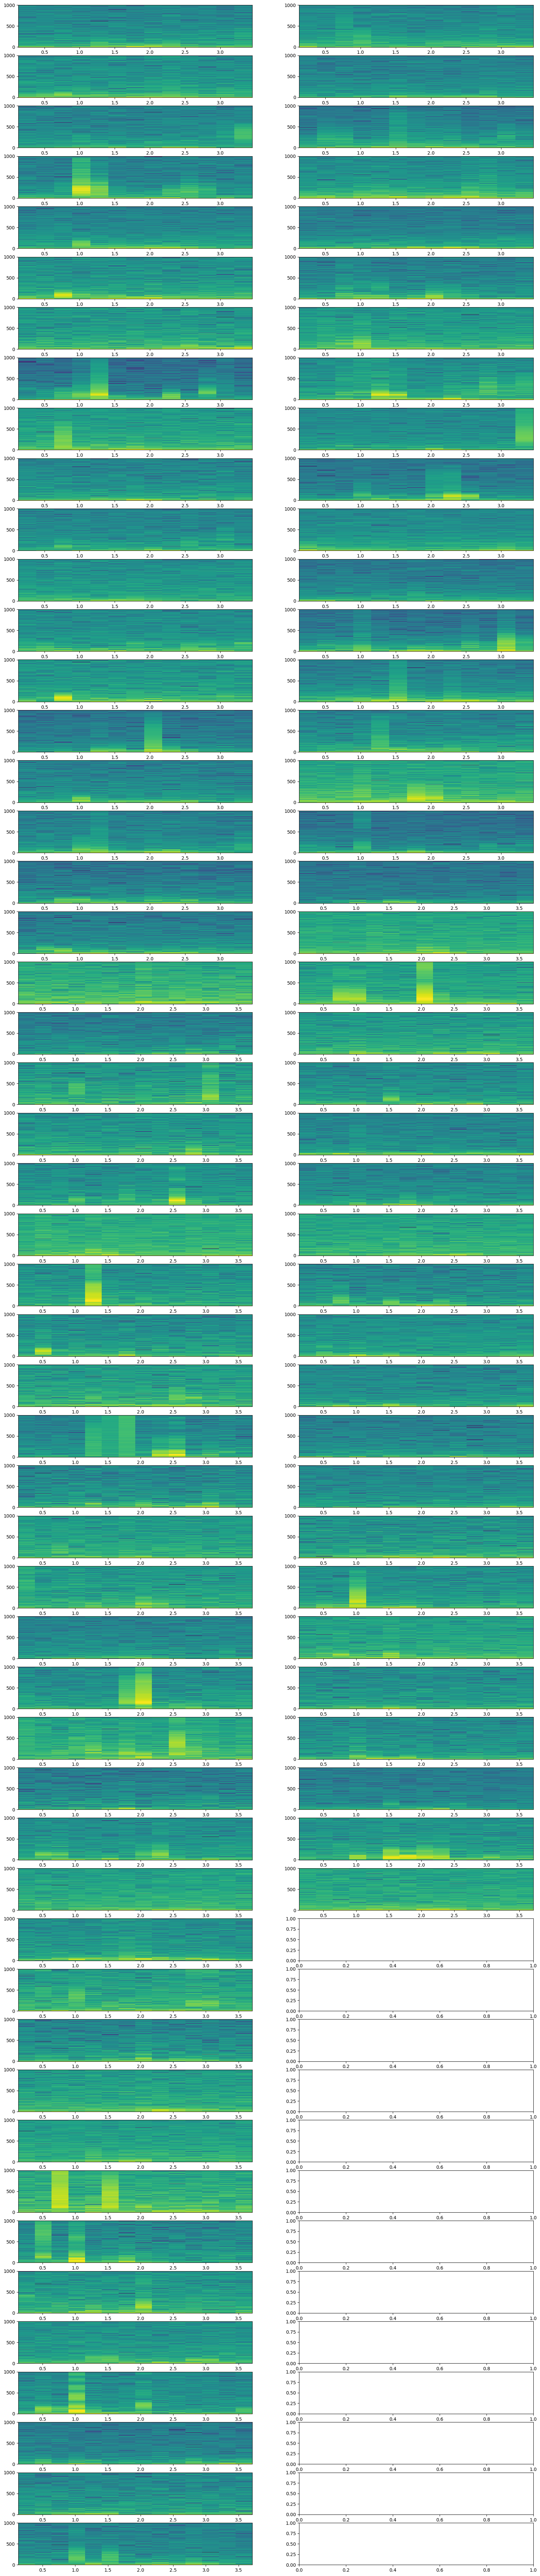

In [188]:
fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm_welch):
    ax[i][0].pcolormesh(n_norm_welch[i][2], n_norm_welch[i][3], 10 * np.log10(n_norm_welch[i][4]), shading='auto')
    if i < len(p_norm_fb):
        ax[i][1].pcolormesh(p_norm_welch[i][2], p_norm_welch[i][3], 10 * np.log10(p_norm_welch[i][4]), shading='auto')

The best method available to estimate the FD of a self-affine signal is PSA. As explained in Section 1.1, an fBm signal has a PSD that
follows the 1/f model. A high value of ˇ indicates a rapid decrease
in the high-frequency content of the signal. A self-affine fBm function in an E-dimensional Euclidean space has its PSD PV(f) ∝ 1/f
with

FD = E + 1 − H
H = B - 1 /2

FD = E + 1 - ((B-1)/2))

If E = 1

FD = 5-B / 2

avg fd normal: 2.500000118442976
avg fd pathology: 2.500000019278581


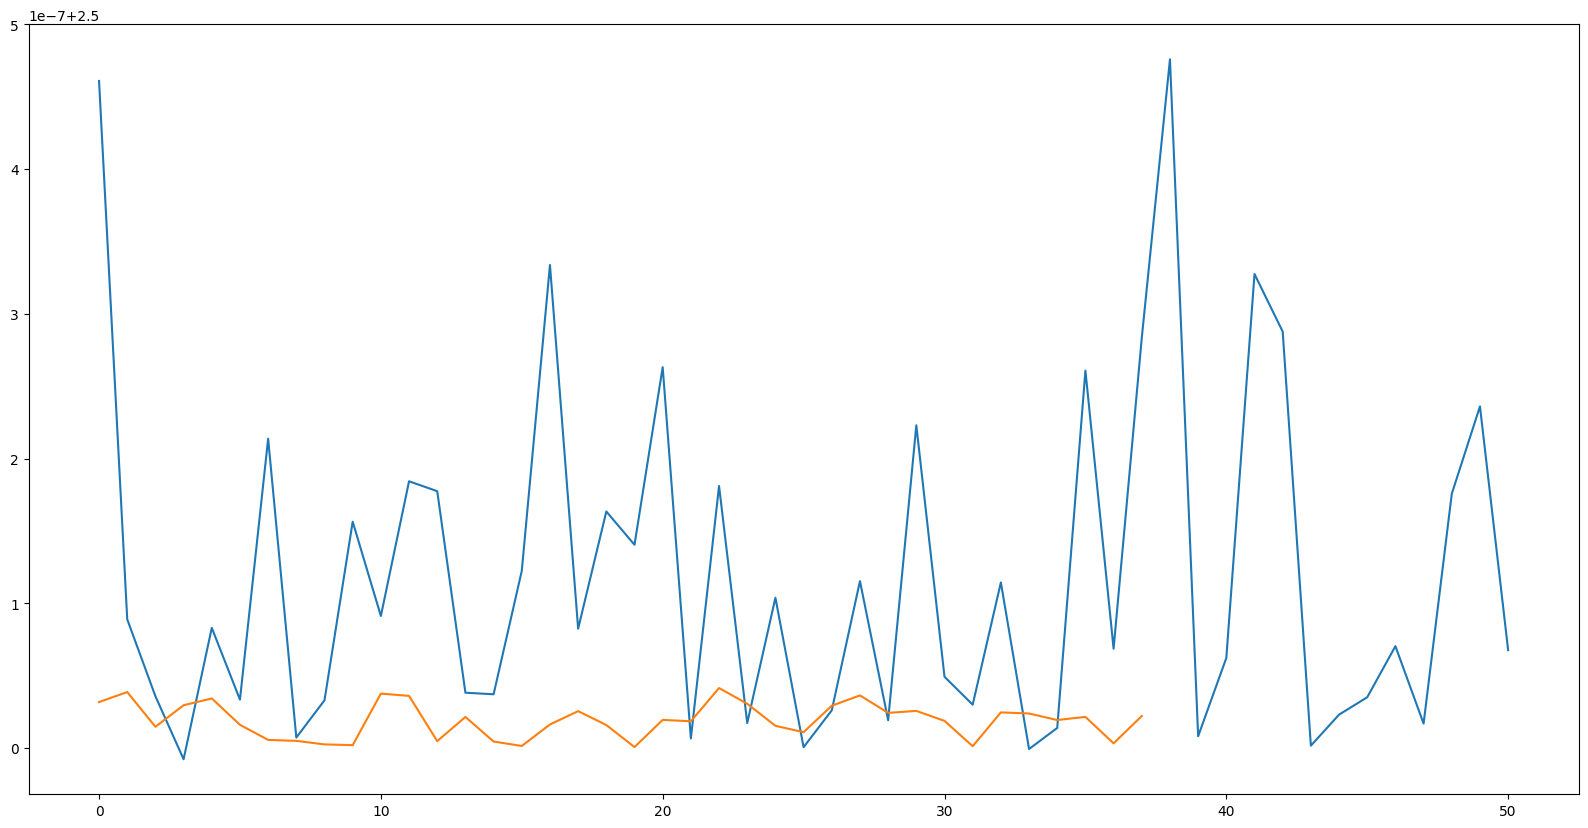

In [195]:
# compute the FD 
n_norm_fd = []
p_norm_fd = []
def compute_fd(slope):
    fd = (5 - slope) / 2
    return fd

for i, s in enumerate(n_slope):
    n_norm_fd.append(compute_fd(s))

for i, s in enumerate(p_slope):
    p_norm_fd.append(compute_fd(s))
    
print(f"avg fd normal: {np.mean(n_norm_fd)}")
print(f"avg fd pathology: {np.mean(p_norm_fd)}")

fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(n_norm_fd)
ax.plot(p_norm_fd)